In [155]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [213]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [214]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


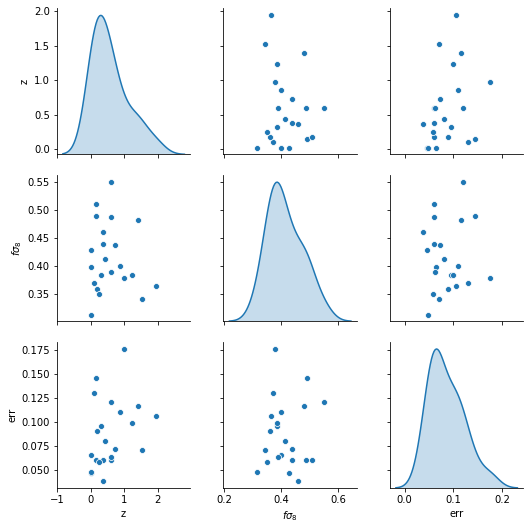

In [215]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [216]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [217]:
z = data[:,0]
y = data[:,1:]
# print(randomize)
np.max(z)

1.944

In [218]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [219]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [220]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [221]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_40 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_41 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_42 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [222]:
# batch_size = 4
batch_size = 1
input_z = Input(shape = (1,))
epochs = 1000

In [223]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.0525 - val_loss: 0.0227
Epoch 2/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0133
Epoch 3/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 4/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 5/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0044
Epoch 6/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0019
Epoch 7/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 8/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 9/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 10/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0020

17/17 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 83/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 84/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 85/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 86/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 87/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 88/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 89/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 90/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 91/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0029
Epoc

17/17 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 163/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 164/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 165/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 166/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 167/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 168/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 169/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 170/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 171/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 243/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 244/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 245/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 246/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 247/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 248/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 249/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 250/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 251/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 323/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 324/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 325/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 326/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 327/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 328/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 329/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 330/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 331/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 403/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 404/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 405/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 406/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 407/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 408/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 409/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 410/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 411/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 483/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 484/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 485/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 486/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 487/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 488/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 489/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 490/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 491/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 563/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 564/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 565/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 566/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 567/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 568/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 569/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 570/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 571/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 643/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 644/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 645/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 646/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 647/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 648/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 649/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 650/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 651/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 723/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 724/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 725/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 726/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 727/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 728/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 729/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 730/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 731/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 803/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 804/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 805/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 806/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 807/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 808/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 809/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 810/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 811/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 883/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 884/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 885/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 886/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 887/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 888/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 889/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 890/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 891/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 963/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 964/1000
17/17 [==============================] - 0s 2ms/step - loss: 9.9763e-04 - val_loss: 0.0030
Epoch 965/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 966/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 967/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 968/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 969/1000
17/17 [==============================] - 0s 2ms/step - loss: 9.9510e-04 - val_loss: 0.0031
Epoch 970/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 971/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0010 - val_

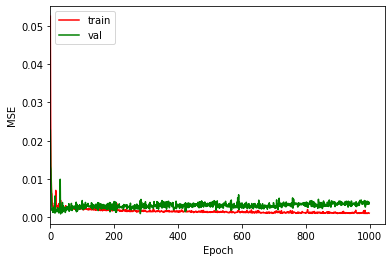

In [224]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_fs8.png", dpi=200)
# plt.savefig("loss_epochs_fs8_1000.png", dpi=200)


In [225]:
# neural_model.save("FFNN_fs8.h5")

In [226]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 0.0009567601955495775 0.0024885754100978374 mil epochs
# 0.0010785672347992659 0.0010806184727698565 500 epochs
# 0.0020020001102238894 0.0008378626080229878 100e
# 0.0021847975440323353 0.0009035465191118419 50e
# 0.002703879727050662 0.0013360671000555158 20e
### 100
# 0.001952524995431304 0.0008627769420854747
# 0.001952524995431304 0.002966993721202016
dif_loss = model_train.history['val_loss'][-1] - model_train.history['val_loss'][-2]
val_loss = model_train.history['val_loss'][-1]
dif_loss, val_loss

0.0009600244229659438 0.0008623932371847332
0.0010573066538199782 0.003819198813289404


(0.0004315401893109083, 0.003819198813289404)

In [227]:
pred = neural_model.predict(z_test)
pred

array([[0.46248633, 0.05845646],
       [0.4754873 , 0.11680996],
       [0.47594768, 0.11355485],
       [0.45994473, 0.10851102],
       [0.45676768, 0.11160079]], dtype=float32)

In [228]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [229]:
ranz = np.random.uniform(0, 2, size=1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


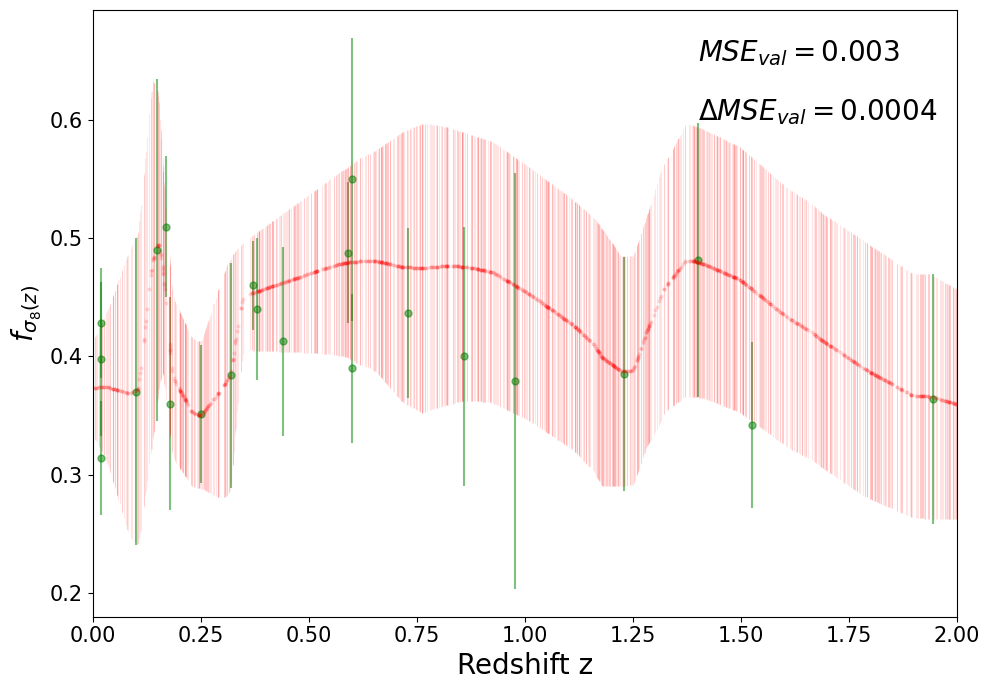

In [231]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.1, c='r',)
plt.ylabel("$f_{\sigma_8(z)}$", fontsize=20)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.text( 1.4, 0.65, "$MSE_{val} = 0.003$", fontsize=20 )
plt.text( 1.4, 0.6, "$\Delta MSE_{val} = 0.0004$", fontsize=20 )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.legend(loc='upper right')
# plt.legend()
plt.savefig("synthetic_fs8_1000.png")

In [20]:
from functools import partial
# Cosmological constants
Om = 0.342
# variance network
s8 = 0.8
h = 1
# def Ezlcdm(a):
#     return np.sqrt(Om*(1/a)**3 + 1 - Om)

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
# #     return Om*(1/a)**3 + 1 - Om
#     w0 = -1.0
#     wa = 0.0
#     rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
#     return (Om/a**3+(1.0-Om)*rhow)

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return h**2*(Om/a**3+(1.0-Om)*rhow)

  
# def growth_lcdm(z):
#     # Equation 7.77 from Doddie
#     af = 1./(1. + z)
#     r = intg.quad(GrowthIntegrand_a_lcdm, 1e-7, af)
#     gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
#     gr *= 5/2.*Om
#     return gr
    

def growth_owacdm(z, w0, wa):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_owacdm, 1e-7, af, args=(w0, wa))
    gr = np.sqrt(RHSquared_a_owacdm(af, w0, wa))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr

# # returns the growth factor as a function of redshift
# def GrowthIntegrand_a_lcdm(a):
#     rhsquareda = RHSquared_a_lcdm(a) 
#     return 1./(rhsquareda*a*a)**(1.5)

def GrowthIntegrand_a_owacdm(a, w0, wa):
    rhsquareda = RHSquared_a_owacdm(a, w0=w0, wa=wa) 
    return 1./(rhsquareda*a*a)**(1.5)

# def fs8lcdm(z):
#     return -s8*(1+z)*derivative(growth_lcdm, z, dx=1e-6)/growth_lcdm(0)

def fs8owacdm(z, w0=-1, wa=0):
    return -s8*(1+z)*derivative(growth_owacdm, z, dx=1e-6, args=(w0, wa))/growth_owacdm(0, w0, wa)

In [21]:
z = np.linspace(0.0, 2, 100)
flcdm = []
fowacdm1 = []
fowacdm2 = []
fowacdm3 = []
fowacdm4 = []

# flcdm = []
for zz in z:
#     flcdm.append(fs8lcdm(zz))
    flcdm.append(fs8owacdm(zz, w0=-1, wa=0.0))
    fowacdm1.append(fs8owacdm(zz, w0=-1, wa=0.5))
    fowacdm2.append(fs8owacdm(zz, w0=-1, wa=-0.5))
    fowacdm3.append(fs8owacdm(zz, w0=-0.8, wa=-0.4))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
fowacdm2 = np.array(fowacdm2)
fowacdm3 = np.array(fowacdm3)

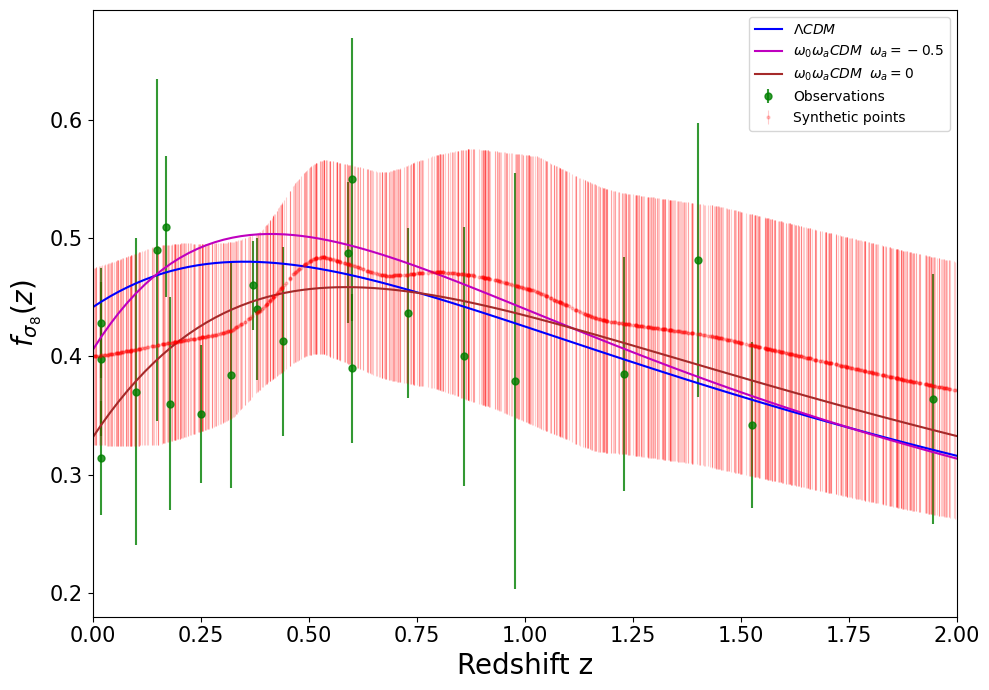

In [55]:
plt.figure(figsize=(10, 7), dpi=100)

z = np.linspace(0, 2, 100)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.2, c='r',)

plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='m')
plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_a=0$', c='brown')
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("$f_{\sigma_8}(z)$", fontsize=20)
plt.tight_layout()
plt.legend()

# plt.savefig("Syntheticfs8.png",dpi=100)

In [23]:
# pred_random.shape, r.shape

In [24]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [25]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)

# np.savetxt("annfs850_.dat",mookHz, delimiter=" ")

In [26]:
mookHz

array([[1.80544272, 0.38623106, 0.10963648],
       [0.30345665, 0.42025024, 0.0760103 ],
       [0.71163695, 0.46867755, 0.09044367],
       [0.8032456 , 0.47134763, 0.0997735 ],
       [1.59618215, 0.40363348, 0.11054216],
       [1.57324664, 0.40554073, 0.1106414 ],
       [1.48410625, 0.41295379, 0.1110272 ],
       [0.02134705, 0.40097505, 0.07610931],
       [0.17421128, 0.41111732, 0.08336823],
       [0.59478624, 0.47774675, 0.08442357],
       [1.74083681, 0.39160374, 0.10991608],
       [1.40578895, 0.41873044, 0.11031562],
       [0.04375788, 0.40203547, 0.07765726],
       [0.26206721, 0.41669989, 0.07886696],
       [1.89438036, 0.37883914, 0.10925147],
       [1.74268502, 0.39145005, 0.10990809],
       [0.50224489, 0.48065472, 0.0793462 ],
       [0.58273621, 0.47917169, 0.08393848],
       [0.27716202, 0.41782907, 0.07784845],
       [1.93026335, 0.37628466, 0.10909218],
       [1.89249653, 0.37899154, 0.10925971],
       [0.49305143, 0.47860214, 0.07837512],
       [1.

In [27]:
predy_reduced[:,1]

array([0.10963648, 0.0760103 , 0.09044367, 0.0997735 , 0.11054216,
       0.1106414 , 0.1110272 , 0.07610931, 0.08336823, 0.08442357,
       0.10991608, 0.11031562, 0.07765726, 0.07886696, 0.10925147,
       0.10990809, 0.0793462 , 0.08393848, 0.07784845, 0.10909218,
       0.10925971, 0.07837512, 0.11092483, 0.08293537, 0.07765726,
       0.10893773, 0.10909218, 0.10909893, 0.11038923, 0.08423984,
       0.06810527, 0.09331463, 0.10965297, 0.10018237, 0.11068492,
       0.08305179, 0.08370066, 0.08363789, 0.11032217, 0.07619935,
       0.07060734, 0.11085847, 0.11415325, 0.11046742, 0.08044319,
       0.0998629 , 0.10894221, 0.10800688, 0.07379571, 0.08766944],
      dtype=float32)

In [28]:
error  = predy_reduced[:,1]**2
error

array([0.01202016, 0.00577757, 0.00818006, 0.00995475, 0.01221957,
       0.01224152, 0.01232704, 0.00579263, 0.00695026, 0.00712734,
       0.01208154, 0.01216954, 0.00603065, 0.00622   , 0.01193588,
       0.01207979, 0.00629582, 0.00704567, 0.00606038, 0.0119011 ,
       0.01193768, 0.00614266, 0.01230432, 0.00687828, 0.00603065,
       0.01186743, 0.0119011 , 0.01190258, 0.01218578, 0.00709635,
       0.00463833, 0.00870762, 0.01202377, 0.01003651, 0.01225115,
       0.0068976 , 0.0070058 , 0.0069953 , 0.01217098, 0.00580634,
       0.0049854 , 0.0122896 , 0.01303096, 0.01220305, 0.00647111,
       0.0099726 , 0.01186841, 0.01166549, 0.00544581, 0.00768593],
      dtype=float32)

In [29]:
diagcov = np.diag(error) #inverso
# np.savetxt("annfs8_cov50_.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

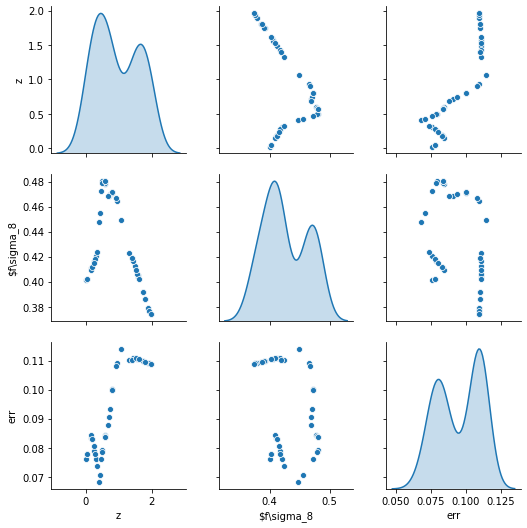

In [30]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("dist50fs8fake_.png")

In [31]:
from astroNN.nn.layers import MCDropout

In [32]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((80,), (22, 1), (20,), (0, 1))

In [33]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model2 = model_regression_dropout(num_hidden=[100, 50, 50])
model2.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model2.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/2000
5/5 [==============================] - 0s 22ms/step - loss: 0.1053 - val_loss: 0.1111
Epoch 2/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.1007 - val_loss: 0.0997
Epoch 3/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0966 - val_loss: 0.1121
Epoch 4/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0912 - val_loss: 0.1150
Epoch 5/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0929 - val_loss: 0.1013
Epoch 6/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0886 - val_loss: 0.0878
Epoch 7/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0859 - val_loss: 0.0948
Epoch 8/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0794 - val_loss: 0.0898
Epoch 9/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0777 - val_loss: 0.0839
Epoch 10/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0760 - val_loss: 0.0732
Epoch 11/2000
5/5 

Epoch 84/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0109
Epoch 85/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0054
Epoch 86/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0114
Epoch 87/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0153 - val_loss: 0.0134
Epoch 88/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0164
Epoch 89/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0075
Epoch 90/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 91/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0043
Epoch 92/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0098
Epoch 93/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0073
Epoch 94/2

5/5 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0048
Epoch 167/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 168/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0010
Epoch 169/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0085
Epoch 170/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 171/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 172/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 173/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 174/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0030
Epoch 175/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 176/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 249/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 250/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 251/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0023
Epoch 252/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0073
Epoch 253/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 254/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 255/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 256/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 257/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 258/2000


5/5 [==============================] - ETA: 0s - loss: 0.003 - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 331/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 332/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 333/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 334/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 335/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 336/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 337/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 338/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 339/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss

Epoch 412/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 413/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 414/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 415/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 416/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 417/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 418/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 419/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 420/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 421/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0030


Epoch 494/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 495/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 496/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 497/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 498/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 499/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 500/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 501/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 502/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 503/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0056


5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 576/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 577/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 578/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 579/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 580/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0060
Epoch 581/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 582/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 583/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 584/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 585/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 658/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 659/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 660/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 661/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 662/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 663/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 664/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 665/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 666/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 667/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 740/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 741/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 742/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 743/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 744/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 745/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 746/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 747/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 748/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 749/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 822/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 823/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 824/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 825/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 826/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 827/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 828/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 829/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 830/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 831/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0051
Epoch 904/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 905/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 906/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 907/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 908/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 909/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 910/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 911/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 912/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 913/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 986/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 987/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 988/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 989/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 990/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 991/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 992/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0054
Epoch 993/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 994/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0053
Epoch 995/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 1067/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 1068/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 1069/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 1070/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 1071/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 1072/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 1073/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 1074/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 1075/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 1148/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 1149/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 1150/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 1151/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 1152/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 1153/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 1154/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 1155/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 1156/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 1229/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 1230/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 1231/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 1232/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 1233/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 1234/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 1235/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 1236/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 1237/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 1310/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 1311/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 1312/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 1313/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 1314/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 1315/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 1316/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 1317/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 1318/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 1391/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 1392/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 1393/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 1394/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 1395/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 1396/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 1397/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 1398/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 1399/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 1472/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 1473/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 1474/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 1475/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 1476/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 1477/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 1478/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 1479/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1480/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 1553/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 1554/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 1555/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 1556/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 1557/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1558/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 1559/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 1560/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 1561/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 1634/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 1635/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1636/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1637/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1638/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 1639/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 1640/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 1641/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 1642/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 1715/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 1716/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 1717/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 1718/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 1719/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 1720/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 1721/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 1722/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 1723/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 1796/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1797/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 1798/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 1799/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 1800/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 1801/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1802/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 1803/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 1804/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 1877/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 1878/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 1879/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 1880/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1881/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 1882/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 1883/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 1884/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 1885/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1958/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 1959/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 1960/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 1961/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 1962/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 1963/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 1964/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 1965/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 1966/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 

In [34]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [35]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.0272192099920986, 0.015291427444306305)

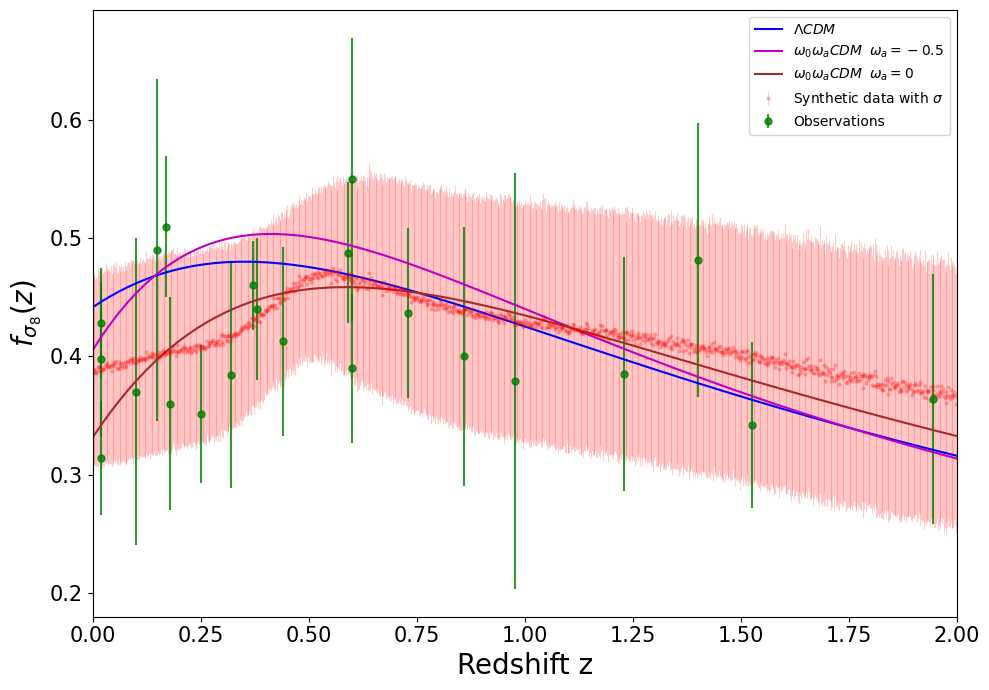

In [51]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.2, c='r',
             label='Synthetic data with $\sigma$')


plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)

plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='m')
plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_a=0$', c='brown')
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("$f_{\sigma_8}(z)$", fontsize=20)
plt.tight_layout()
plt.legend()


plt.savefig('fs8_dropoutb.png', dpi=100)

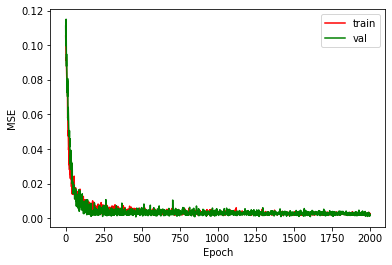

In [37]:
plt.plot(model2_train.history['loss'], color='r')
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.legend(['train', 'val'], loc='upper right')
# plt.savefig('lossfs8dropout.png', dpi=100)

In [175]:
model2.save("FFNN+MC-DO_fs8.h5")

In [39]:
mookdpfs8 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("annfs850dropout.dat",mookdpfs8, delimiter=" ")

In [40]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("annfs8_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

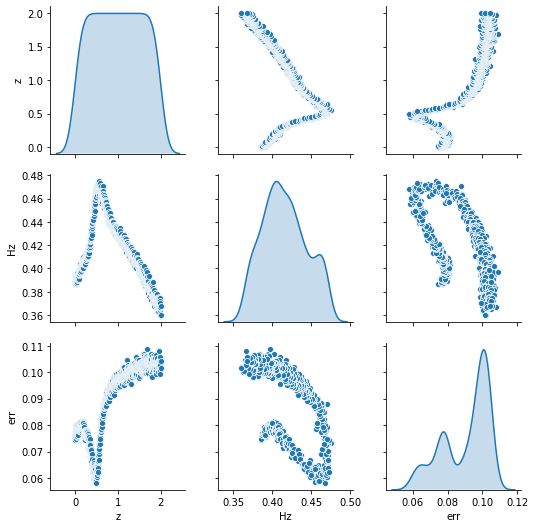

In [41]:
dfMook = pd.DataFrame(mookdpfs8, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50fs8dmookdropout.png")